In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('train.csv')

In [6]:
# var_count = pd.DataFrame(train_df.apply(pd.Series.nunique, axis=0))
# var_count.reset_index(inplace=True)
# var_count.columns = ['variable', 'unique_count']
# var_count.sort_values('unique_count', ascending=True, inplace=True)
# var_count.head()

,variable,unique_count
1,target,2
70,var_68,451
93,var_91,7962
110,var_108,8525
105,var_103,9376


In [7]:
# train_df.var_68.unique()
# train_df.var_68.describe()

count    200000.000000
mean          5.018893
std           0.007186
min           4.993800
25%           5.014000
50%           5.019100
75%           5.024100
max           5.046900
Name: var_68, dtype: float64

In [21]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
import xgboost as xgb

In [9]:
train_x = train_df.drop(columns=['ID_code', 'target'])
train_y = train_df['target']
print(train_x.shape, train_y.shape)
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(200000, 200) (200000,)
(140000, 200) (60000, 200) (140000,) (60000,)


In [10]:
# model1 = Lasso(alpha=0.1)
# model1.fit(x_train, y_train)
# y_predict = model1.predict(x_test)
# y_predict[0:5]
# print(max(y_predict), min(y_predict))
# y_predict2 = y_predict
# y_predict2[y_predict2>0.5] = 1
# y_predict2[y_predict2<=0.5] = 0
# print(confusion_matrix(y_predict2, y_test))

In [11]:
class_names = train_df.target.unique()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_predict2, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_predict2, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [12]:
# # fit model no training data
# xgb_model = XGBClassifier(silent=False)
# xgb_model.fit(x_train, y_train)
# y_predict = xgb_model.predict(x_test)
# plot_confusion_matrix(y_test, y_predict, classes=class_names,
#                       title='Confusion matrix, without normalization')

# plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

In [30]:
x_train_with_eval, x_eval, y_train_with_eval, y_eval = train_test_split(x_train, y_train, 
                                                                        test_size = 0.3)
print(x_train_with_eval.shape, x_eval.shape, y_train_with_eval.shape, y_eval.shape)

dtrain = xgb.DMatrix(x_train_with_eval, label=y_train_with_eval)
deval = xgb.DMatrix(x_eval, label=y_eval)

# param = {'max_depth': 2, 'eta': 0.1, 'verbosity': 2, 'objective': 'binary:logistic', 
#          'eval_metric': 'auc', 'subsample':0.8, 'alpha': 0.2, 'early_stopping_rounds': 20}

max_depth = np.arange(2,10,2)
num_round = np.arange(2000,10000,2000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

param = {'eta': 0.1, 'verbosity': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 
         'subsample':0.8, 'alpha': 0.2, 'early_stopping_rounds': 20}

param_grid = dict()
param_grid['max_depth'] = max_depth
param_grid['num_round'] = num_round

xgb_grid_search = XGBClassifier(param=param)
grid_search = GridSearchCV(xgb_grid_search, param_grid=param_grid, n_jobs=-1, cv=kfold, verbose=20, 
                           scoring='roc_auc')
grid_result = grid_search.fit(x_train, y_train)
# evallist = [(deval, 'eval'), (dtrain, 'train')]

# # xgb_model_with_params = xgb.train(param, dtrain, num_round, evallist)
# xgb_model_with_params = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=4, 
#                                verbose_eval=True)

(98000, 200) (42000, 200) (98000,) (42000,)


/Users/abhishek/My Project/santander-transaction/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  9

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 185.4min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 185.5min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 185.5min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 185.5min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 185.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 204.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 204.8min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 204.8min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 204.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 204.9min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 205.0min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 205.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 205.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 223.8min
[Parallel(n_jobs=-1)]: Done 154 out of 160 | elapsed: 243.5min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done 160 out 

In [34]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.851464 using {'max_depth': 6, 'num_round': 2000}
0.813379 (0.005716) with: {'max_depth': 2, 'num_round': 2000}
0.813379 (0.005716) with: {'max_depth': 2, 'num_round': 4000}
0.813379 (0.005716) with: {'max_depth': 2, 'num_round': 6000}
0.813379 (0.005716) with: {'max_depth': 2, 'num_round': 8000}
0.841618 (0.005784) with: {'max_depth': 4, 'num_round': 2000}
0.841618 (0.005784) with: {'max_depth': 4, 'num_round': 4000}
0.841618 (0.005784) with: {'max_depth': 4, 'num_round': 6000}
0.841618 (0.005784) with: {'max_depth': 4, 'num_round': 8000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 2000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 4000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 6000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 8000}
0.851197 (0.005168) with: {'max_depth': 8, 'num_round': 2000}
0.851197 (0.005168) with: {'max_depth': 8, 'num_round': 4000}
0.851197 (0.005168) with: {'max_depth': 8, 'num_round': 6000}
0.851197 (0.0

In [ ]:
def summarize_cv_results(grid_result):
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [41]:
def perform_grid_search(model, x_train, y_train, param_grid, kfold_splits=10, num_jobs = -1, 
                        verbose_num = 20, scoring_method = 'roc_auc'):
    
    kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=100)
    grid_search = GridSearchCV(model, param_grid, n_jobs=num_jobs, cv=kfold, 
                               verbose=verbose_num, scoring=scoring_method)
    grid_result = grid_search.fit(x_train, y_train)
    return grid_result

In [35]:
max_depth_2 = np.arange(5,8,1)
num_round_2 = np.arange(500,4000,500)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

param_grid_2 = dict()
param_grid_2['max_depth'] = max_depth_2
param_grid_2['num_round'] = num_round_2

xgb_grid_search_2 = XGBClassifier(param=param)
grid_search_2 = GridSearchCV(xgb_grid_search_2, param_grid=param_grid_2, n_jobs=-1, cv=kfold, 
                             verbose=20, scoring='roc_auc')
grid_result_2 = grid_search_2.fit(x_train, y_train)


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 22

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 242.6min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 242.7min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 242.8min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 242.9min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 246.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 247.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 261.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 262.5min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 262.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 262.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 266.3min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 266.5min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 269.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 271.3min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 285.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 2

In [40]:
summarize_cv_results(grid_result_2)

Best: 0.852832 using {'max_depth': 7, 'num_round': 500}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 500}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 1000}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 1500}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 2000}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 2500}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 3000}
0.847043 (0.005371) with: {'max_depth': 5, 'num_round': 3500}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 500}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 1000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 1500}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 2000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 2500}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 3000}
0.851464 (0.003896) with: {'max_depth': 6, 'num_round': 3500}
0.852832 (0.005060) with: {'max_depth': 7, 'num_round': 500}
0.852832 (0.00506

In [46]:
param['max_depth'] = 7
xgb_grid_search_3 = XGBClassifier(param=param)
param_grid_3 = dict()
param_grid_3['num_boost_round'] = np.arange(100,1000,300)
grid_result_3 = perform_grid_search(model=xgb_grid_search_3, x_train=x_train, y_train=y_train,
                                   param_grid=param_grid_3, kfold_splits=2)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  4.4min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  4.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  4.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.5min finished


In [48]:
param

{'max_depth': 7, 'num_round': 8000}

In [49]:
param_grid_3

{'num_boost_round': array([100, 400, 700])}

In [47]:
summarize_cv_results(grid_result_3)

Best: 0.828269 using {'num_boost_round': 100}
0.828269 (0.002875) with: {'num_boost_round': 100}
0.828269 (0.002875) with: {'num_boost_round': 400}
0.828269 (0.002875) with: {'num_boost_round': 700}


In [45]:
param = {'eta': 0.1, 'verbosity': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc', 
         'subsample':0.8, 'alpha': 0.2, 'early_stopping_rounds': 20, 'max_depth':7,
        }


{'max_depth': 7, 'num_round': 8000}

In [51]:
num_round

array([2000, 4000, 6000, 8000])

In [50]:
param['early_stopping_rounds']=20
xgb_model_with_params_early_stop = xgb.cv(param, dtrain, num_boost_round=num_round, nfold=4, 
                               verbose_eval=True)

TypeError: only integer scalar arrays can be converted to a scalar index

In [19]:
xgb_model_with_params.best_iteration

9999

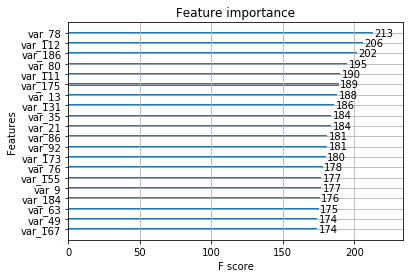

In [20]:
xgb.plot_importance(xgb_model_with_params, max_num_features=20)